# Analysis of motor tests of exposures 86409 and 86415

## Startup

### Logging

Use the logger to help follow progress, and recort when cells are run.

In [1]:
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logger.info("Starting")

2021-07-22 13:08:58,144 Starting


### Imports

In [2]:
import os
import re
from functools import partial
from collections import namedtuple
import numbers
import getpass
import psycopg2
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation
from astropy.stats import biweight_midvariance

In [3]:
import desimeter.transform
import desimeter.transform.pos2ptl as pos2ptl

In [4]:
%load_ext autoreload
%autoreload 1

The `motortest` code is in the same directory as this notebook, so should be visible.

In [5]:
%aimport motortest

### Configuration

If we do not have it already (e.g. because the notebook is being rerun), query for the DOS database password, echo dots instead of showing the password.

In [6]:
try:
    assert len(passwd)>0
except NameError:
    print("Site database password: ", end="")
    passwd = getpass.getpass()

Site database password: 

 ······


Plotting:

In [7]:
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)

In [8]:
test_coord = {86409: 'p', 86415: 't'}
test_expid = {c: e for e, c in test_coord.items()}

# Collect the data

Query the data from the observatory database, and store the results in a pickle so we don't have to repeat the query each time.

In [9]:
try:
    t_moves = pd.read_pickle('t_moves.pkl')
    logger.info("Read t_moves from local pickle")
except FileNotFoundError: 
    logger.info("Querying theta test moves")
    t_moves = motortest.get_moves(test_expid['t'], passwd)
    logger.info("Finished query")
    t_moves.to_pickle('t_moves.pkl')
    logger.info("Wrote query results to t_moves.pkl")

2021-07-22 13:09:04,854 Read t_moves from local pickle


In [10]:
try:
    p_moves = pd.read_pickle('p_moves.pkl')
    logger.info("Read p_moves from local pickle")
except FileNotFoundError: 
    logger.info("Querying phi test moves")
    p_moves = motortest.get_moves(test_expid['p'], passwd)
    logger.info("Finished query")
    p_moves.to_pickle('p_moves.pkl')
    logger.info("Wrote query results to p_moves.pkl")

2021-07-22 13:09:05,162 Read p_moves from local pickle


# Calculate derived quantities

In [11]:
motortest.compute_derived_columns(t_moves, motortest.T_MOVE_BINS, motortest.P_MOVE_BINS, 't', inplace=True)
motortest.compute_derived_columns(p_moves, motortest.T_MOVE_BINS, motortest.P_MOVE_BINS, 'p', inplace=True)

device_loc                    time_recorded  \
petal_id pos_id pos_move_index                                                
2        M01084 22109                  128 2021-04-27 01:25:57.931540+00:00   
                22110                  128 2021-04-27 01:27:09.710088+00:00   
                22111                  128 2021-04-27 01:28:30.297723+00:00   
                22112                  128 2021-04-27 01:29:48.161198+00:00   
                22113                  128 2021-04-27 01:31:11.380855+00:00   
...                                    ...                              ...   
11       M08474 16634                  368 2021-04-27 01:52:52.741820+00:00   
                16635                  368 2021-04-27 01:54:09.942365+00:00   
                16636                  368 2021-04-27 01:55:27.154532+00:00   
                16637                  368 2021-04-27 01:56:44.338866+00:00   
                16638                  368 2021-04-27 01:58:16.175005+00:00   

                               bus_id      pos_t       pos_p  previous_pos_t  \
petal_id pos_id pos_move_index                                                 
2        M01084 22109           can13 -37.501359  169.998416             NaN   
                22110           can13 -37.501359  177.999970      -37.501359   
                22111           can13 -37.501359  181.999859      -37.501359   
                22112           can13 -37.501359  161.995972      -37.501359   
                22113           can13 -37.501359  181.999859      -37.501359   
...                               ...        ...         ...             ...   
11       M08474 16634           can22 -93.872138  148.975133      -93.872138   
                16635           can22 -93.872138  148.975133      -93.872138   
                16636           can22 -93.872138  148.975133      -93.872138   
                16637           can22 -93.872138  148.975133      -93.872138   
                16638           can22 -93.872138  148.975133      -93.872138   

                                previous_pos_p       obs_x       obs_y  \
petal_id pos_id pos_move_index                                           
2        M01084 22109                      NaN -190.716177   87.147834   
                22110               169.998416 -190.304636   87.002865   
                22111               177.999970 -190.154137   86.959701   
                22112               181.999859 -191.031681   87.292206   
                22113               161.995972 -190.154776   86.969183   
...                                        ...         ...         ...   
11       M08474 16634               148.975133 -232.098913  226.848040   
                16635               148.975133 -232.094042  226.834646   
                16636               148.975133 -232.082112  226.855855   
                16637               148.975133 -232.119204  226.846485   
                16638               148.975133 -232.083286  226.830312   

                                     ptl_x  ...  move_t  prev_calc_p  \
petal_id pos_id pos_move_index              ...                        
2        M01084 22109           205.622949  ...     0.0          NaN   
                22110           205.204813  ...     0.0   170.028499   
                22111           205.057693  ...     0.0   177.851901   
                22112           205.963047  ...     0.0   181.229437   
                22113           205.063784  ...     0.0   163.508231   
...                                    ...  ...     ...          ...   
11       M08474 16634           287.481559  ...     0.0   149.038945   
                16635           287.467315  ...     0.0   148.923483   
                16636           287.483791  ...     0.0   148.687358   
                16637           287.486359  ...     0.0   149.150063   
                16638           287.459865  ...     0.0   148.797650   

                                  dcalc_p prev_calc_t    dcalc_

In [12]:
t_moves.describe().T

,count,mean,std,min,25%,50%,75%,max
device_loc,144383.0,2.551949e+02,1.480238e+02,0.000000,128.000000,254.000000,381.000000,5.260000e+02
pos_t,144383.0,8.579703e+00,3.967044e+01,-195.423570,-4.957648,9.745516,25.561858,1.923351e+02
pos_p,144383.0,1.486285e+02,8.942520e+00,-5.555894,148.311778,149.713087,150.835009,1.834258e+02
previous_pos_t,139402.0,8.932786e+00,3.991504e+01,-195.423570,-5.143890,9.965137,26.111862,1.923351e+02
previous_pos_p,139402.0,1.486004e+02,8.974193e+00,-5.555894,148.257244,149.647872,150.878005,1.834258e+02
obs_x,144362.0,5.888943e-02,2.020548e+02,-405.673215,-166.160603,0.343075,166.604242,4.056394e+02
obs_y,144362.0,-3.469934e-01,2.024665e+02,-407.091878,-164.272583,-3.764786,163.046929,4.081582e+02
ptl_x,144362.0,2.557644e+02,8.904646e+01,26.713210,193.024978,267.026300,329.106290,4.083971e+02
ptl_y,144362.0,7.658283e+01,5.104359e+01,0.248911,32.603908,69.149758,114.473801,1.964475e+02
ptl_z,144362.0,-9.039888e+00,5.207721e+00,-18.833764,-13.349401,-8.993410,-4.602343,-7.397716e-02


In [13]:
p_moves.describe().T

,count,mean,std,min,25%,50%,75%,max
device_loc,124456.0,2.551916e+02,1.480267e+02,0.000000,128.000000,254.000000,381.000000,5.260000e+02
pos_t,124456.0,-2.899946e+00,9.729308e+01,-195.534492,-90.969254,-0.000103,82.045914,1.921623e+02
pos_p,124456.0,1.620894e+02,1.713107e+01,-5.555894,149.999957,168.999773,177.001468,1.836323e+02
previous_pos_t,119475.0,-2.969410e+00,9.910202e+01,-195.534492,-95.519333,-0.636494,87.877675,1.921623e+02
previous_pos_p,119475.0,1.626188e+02,1.720303e+01,-5.555894,150.003448,168.999857,177.001512,1.836323e+02
obs_x,124306.0,1.358398e-02,2.021240e+02,-405.383297,-166.355766,0.024208,165.979086,4.053341e+02
obs_y,124306.0,-3.966351e-01,2.023059e+02,-409.121306,-164.635144,-4.102194,163.049137,4.085780e+02
ptl_x,124306.0,2.557086e+02,8.900435e+01,26.408882,192.904145,267.462704,329.527807,4.084296e+02
ptl_y,124306.0,7.657794e+01,5.104008e+01,0.235363,32.346163,68.618287,113.829220,1.973389e+02
ptl_z,124306.0,-9.035661e+00,5.205684e+00,-18.864608,-13.320134,-8.977389,-4.608105,-7.350705e-02


# Limits the rows to the useful ones

The "working_moves" derived column tests for whether the move is in the coordinate being tested, that its command is consistent with being one of the test moves, whether its retracted, and whether it is classified as non-functional. If we want to include positioners that are rectacted or classified as non-fuctional, we need to test just of the first two.

In [14]:
exclude_positioners_marked_bad = False

In [15]:
if exclude_positioners_marked_bad:
    t_moves = t_moves.query('working_moves')
    p_moves = p_moves.query('working_moves')
else:
    t_moves = t_moves.query('has_test_p and has_dTdP')
    p_moves = p_moves.query('has_test_t and has_dTdP')

# Summarize distributions of measured moves by bin in commanded move

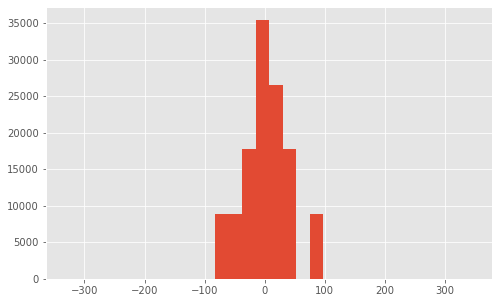

In [16]:
t_moves['move_t'].hist(bins=30)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aaae0950a30>)

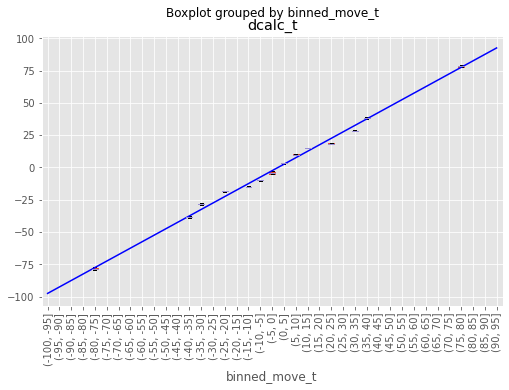

In [17]:
motortest.plot_move_boxplot(t_moves, motortest.T_MOVE_BINS, 't')

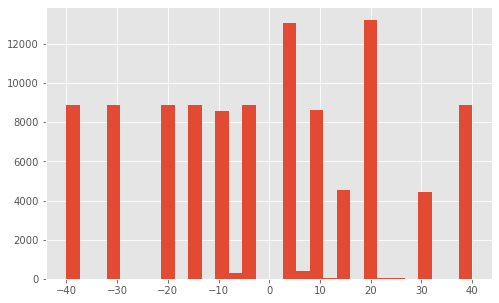

In [18]:
p_moves['move_p'].hist(bins=30)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aaae228a4f0>)

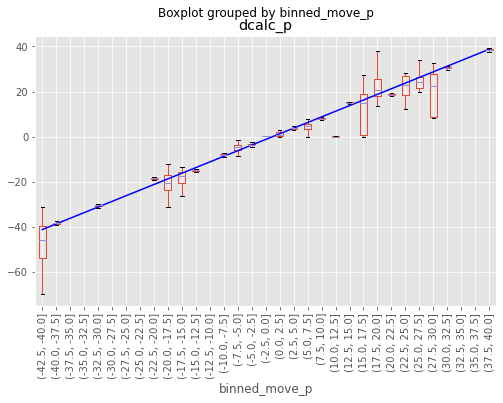

In [19]:
motortest.plot_move_boxplot(p_moves, motortest.P_MOVE_BINS, 'p')

# Compare measured and expected `ptl_x` and `ptl_y` and mark discrepancies

(<Figure size 1080x576 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae228a280>,
       dtype=object))

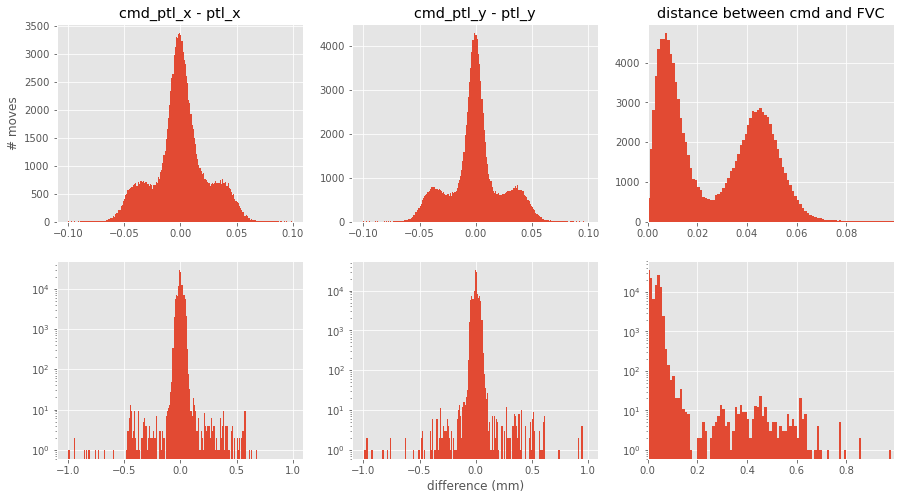

In [20]:
motortest.plot_dist_hists(t_moves)

(<Figure size 1080x576 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaadcd40430>,
       dtype=object))

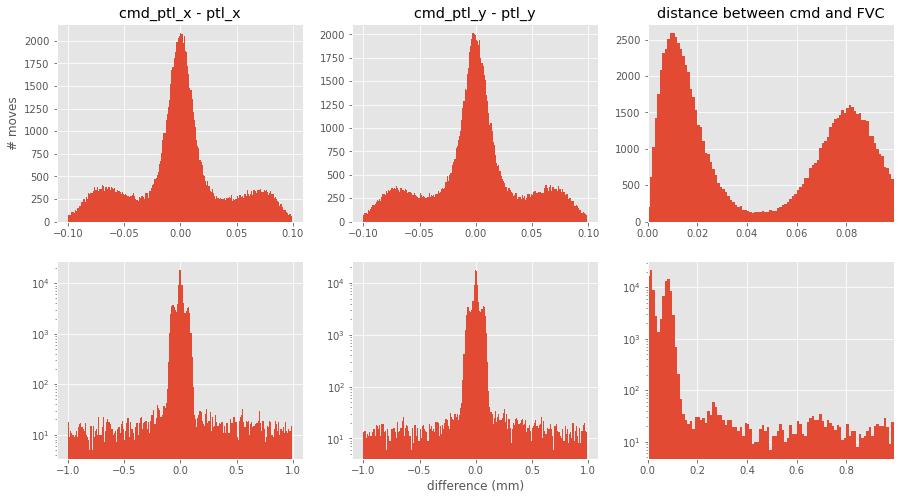

In [21]:
motortest.plot_dist_hists(p_moves)

Estimate the variance in x and y using a robust variance estimator:

In [22]:
t_ptl_diff_var = t_moves[['ptl_x_diff', 'ptl_y_diff']].dropna().apply(biweight_midvariance)
np.sqrt(t_ptl_diff_var)

ptl_x_diff    0.023801
ptl_y_diff    0.022924
dtype: float64

In [23]:
p_ptl_diff_var = p_moves[['ptl_x_diff', 'ptl_y_diff']].dropna().apply(biweight_midvariance)
np.sqrt(p_ptl_diff_var)

ptl_x_diff    0.042635
ptl_y_diff    0.043089
dtype: float64

There are two apparent peaks in the distance distribution, divided around 0.05mm. The second peak seems to extend to 0.12mm or so.

Create flags for each peak. Count positioners in the second peak as mismatches.

In [24]:
t_moves = motortest.assign_distance_peaks(t_moves, 0.025, 0.7)
p_moves = motortest.assign_distance_peaks(p_moves, 0.05, 0.12)

Count the numbers of positioners with at least one mismatched position:

In [25]:
t_mismatched = t_moves.groupby(['petal_id', 'pos_id'])['mismatch'].any()
p_mismatched = t_moves.groupby(['petal_id', 'pos_id'])['mismatch'].any()
pd.DataFrame({'t': t_mismatched.value_counts(), 'p': p_mismatched.value_counts()})

,t,p
False,4429,4429
True,4,4


Count the numbers of positioners with all moves in peak 1:

In [26]:
t_peak1 = t_moves.groupby(['petal_id', 'pos_id'])['peak1'].all()
p_peak1 = p_moves.groupby(['petal_id', 'pos_id'])['peak1'].all()
pd.DataFrame({'t': t_peak1.value_counts(), 'p': p_peak1.value_counts()})

,t,p
False,4401,4430
True,32,2


Count positioners moves in peak 2 but none in peak 1

In [27]:
t_peak2 = ~ (t_mismatched | t_peak1)
p_peak2 = ~ (p_mismatched | p_peak1)
pd.DataFrame({'t': t_peak2.value_counts(), 'p': p_peak2.value_counts()})

,t,p
True,4397,4427
False,36,6


See if mismatches depend on the magnitude of the move.

(<Figure size 648x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae41ca2e0>,
       dtype=object))

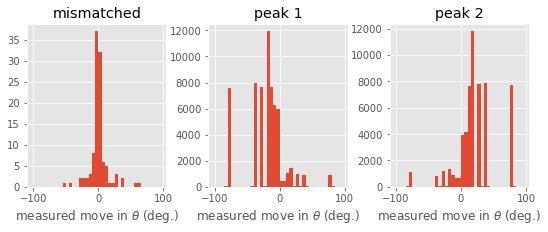

In [28]:
motortest.plot_move_histogram_by_peak(t_moves, motortest.T_MOVE_BINS, 't')

(<Figure size 648x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae89205e0>,
       dtype=object))

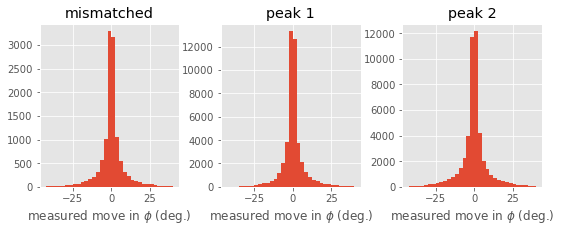

In [29]:
motortest.plot_move_histogram_by_peak(p_moves, motortest.P_MOVE_BINS, 'p')

It looks like most moves in peak 1 are negative moves in θ, while those in peak 2 are positive.

## Fit lines with `numpy.polyfit`

In [30]:
logger.info("Fitting moves in theta")
t_move_fits = motortest.fit_move_lines(t_moves, exog_col='move_t', endog_col='dcalc_t', x_col='ptl_x', y_col='ptl_y')
logger.info("Done")

2021-07-22 13:09:46,394 Fitting moves in theta
2021-07-22 13:10:25,528 Done


In [31]:
logger.info("Fitting moves in phi")
p_move_fits = motortest.fit_move_lines(p_moves, exog_col='move_p', endog_col='dcalc_p', x_col='ptl_x', y_col='ptl_y')
logger.info("Done")

2021-07-22 13:10:25,536 Fitting moves in phi
2021-07-22 13:11:04,364 Done


## Examine residuals from fit lines

### Residuals in tested angle as a function of fit parameters

(<Figure size 720x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae9c92f70>,
       dtype=object))

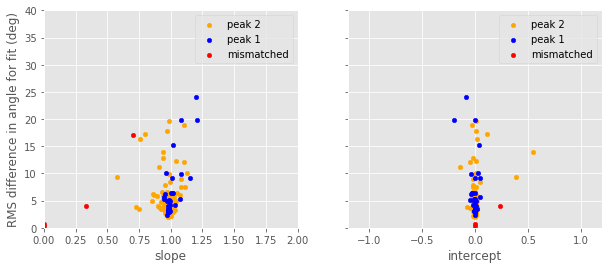

In [32]:
motortest.plot_residuals_by_param(t_moves, t_move_fits)

(<Figure size 720x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae9748070>,
       dtype=object))

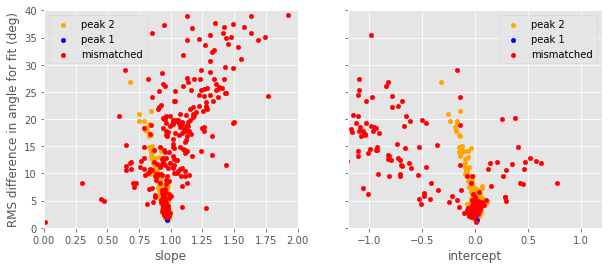

In [33]:
motortest.plot_residuals_by_param(p_moves, p_move_fits)

As I might expect, positioners with all moves in peak 1 have best fits with a slope near 1 and intercept of 0.

Those in peak two are sprayed across lines, with the higher residuals on positoners with lines whose best fit is furthest from that expected.

Best fits of positionors with mismatches could be anywhere.

### Distances from expected positoins as a function of fit parameters

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae962a4f0>,
       dtype=object))

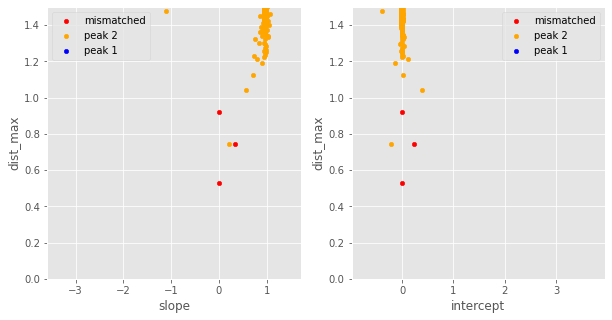

In [34]:
motortest.plot_distances_by_param(t_moves, t_move_fits)

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae9496670>,
       dtype=object))

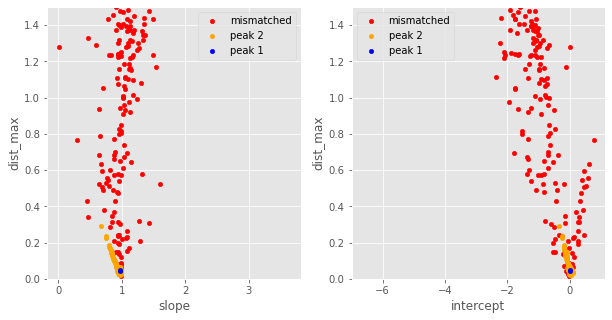

In [35]:
motortest.plot_distances_by_param(p_moves, p_move_fits)

# Examine sample fits

## Find some fits with slope far from 1, but lower residuals

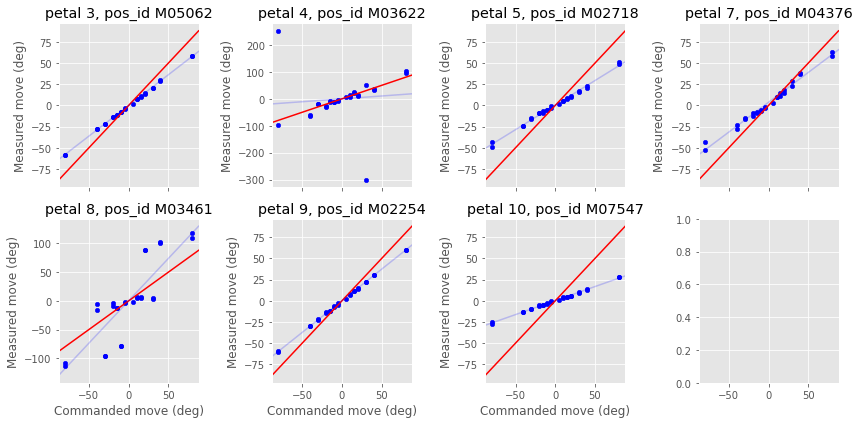

In [36]:
fit_stats = motortest.plot_moves(t_move_fits.query('(0.1<slope<1.9) and (abs(slope-1)>0.25)'), t_moves, ncols=4)

In [37]:
len(fit_stats.query('(0.1<slope<1.9) and (abs(slope-1)>0.1)'))

7

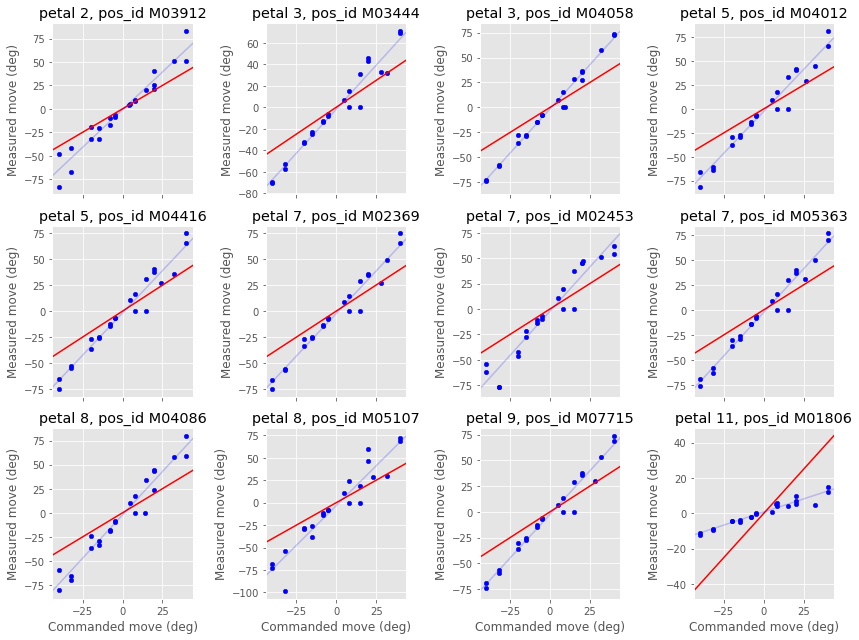

In [38]:
fit_stats = motortest.plot_moves(p_move_fits.query('(0.1<slope<1.9) and (abs(slope-1)>0.6)'), p_moves, coordinate='p', ncols=4)

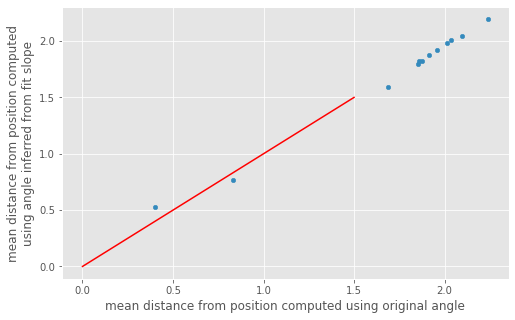

In [39]:
motortest.plot_fit_improvement(fit_stats)

## Error in move vs. magnitude of move

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(<Figure size 720x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae9919a60>,
       dtype=object))

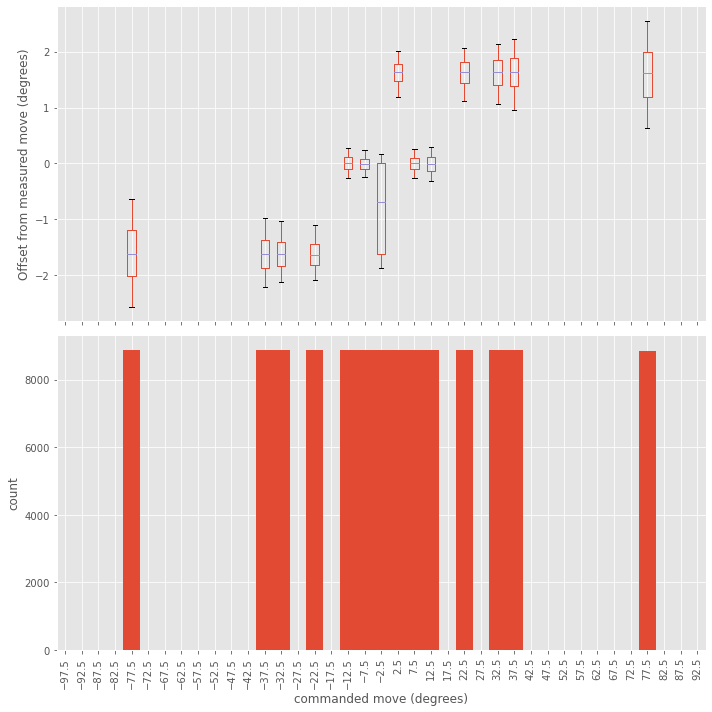

In [40]:
motortest.plot_move_difference_boxplot(t_moves, 't', motortest.T_MOVE_BINS)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(<Figure size 720x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaea811370>,
       dtype=object))

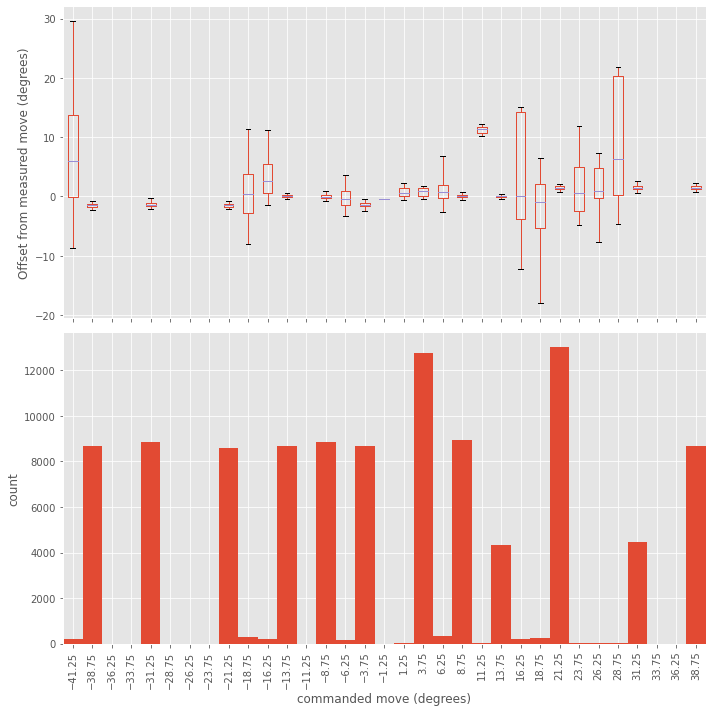

In [41]:
motortest.plot_move_difference_boxplot(p_moves, 'p', motortest.P_MOVE_BINS)

## Looking at the motion of one positioner on the focal plane

(<Figure size 576x576 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaeabbd520>,
       dtype=object))

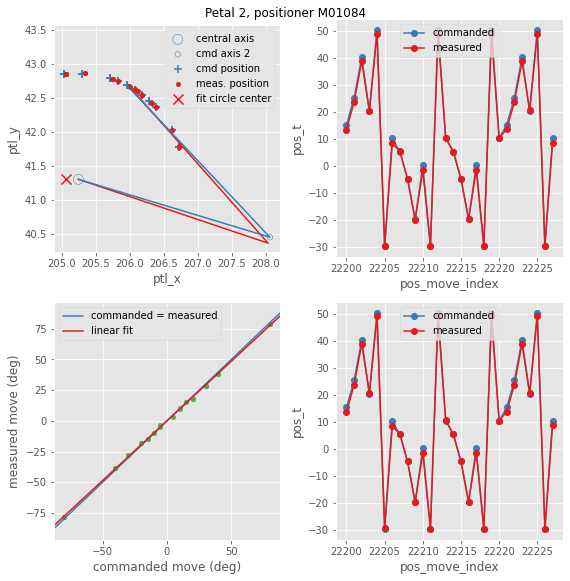

In [42]:
motortest.multi_plot_pos(2, 'M01084', t_moves, t_move_fits, figsize=(8,8))

(<Figure size 576x576 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaecc445e0>,
       dtype=object))

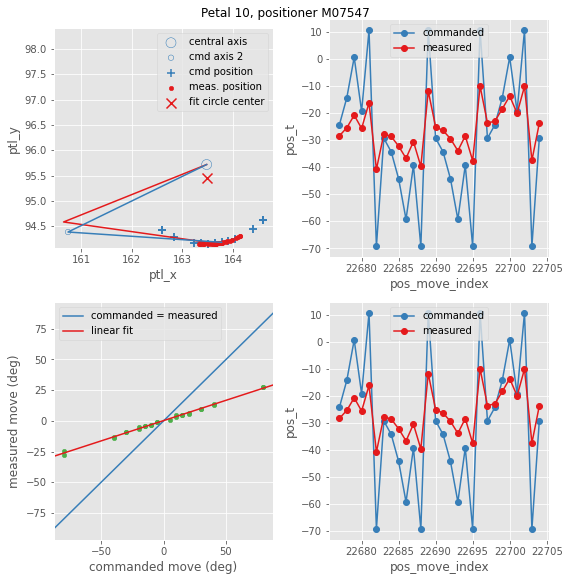

In [43]:
motortest.multi_plot_pos(10, 'M07547', t_moves, t_move_fits, figsize=(8,8))

(<Figure size 576x576 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaece095b0>,
       dtype=object))

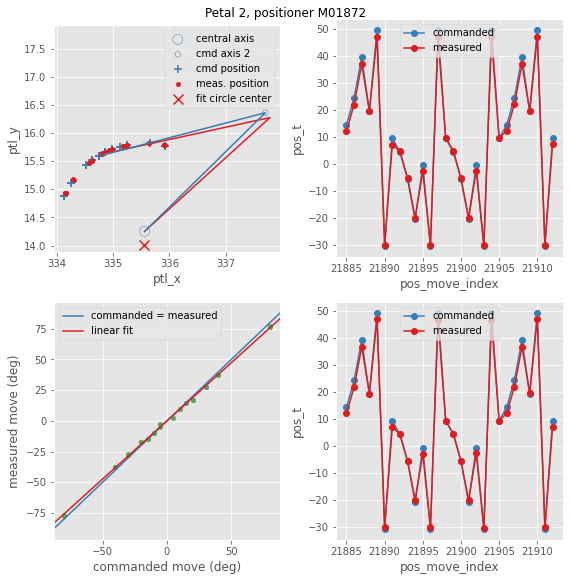

In [44]:
motortest.multi_plot_pos(2, 'M01872', t_moves, t_move_fits, figsize=(8,8))

(<Figure size 576x576 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaed0675b0>,
       dtype=object))

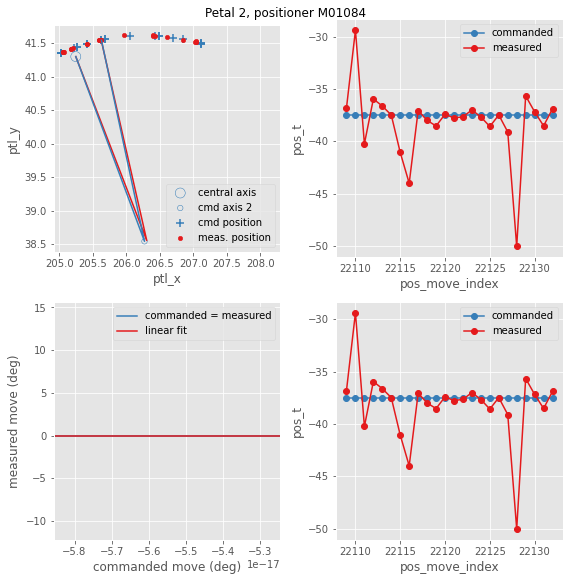

In [45]:
motortest.multi_plot_pos(2, 'M01084', p_moves, p_move_fits, 'p', figsize=(8,8))

(<Figure size 576x576 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaed1c4f70>,
       dtype=object))

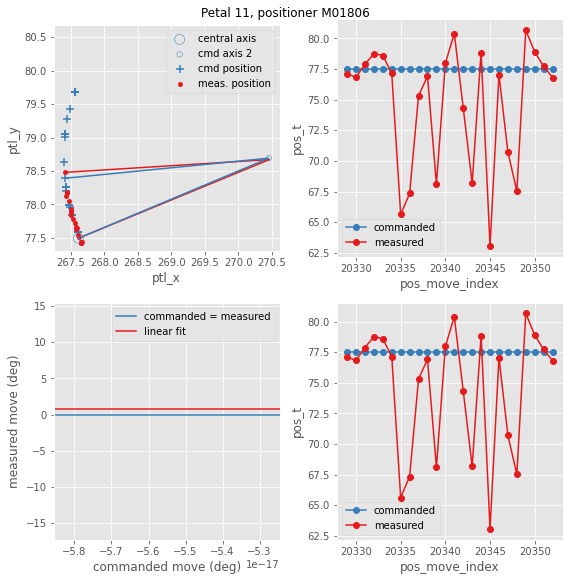

In [46]:
motortest.multi_plot_pos(11, 'M01806', p_moves, p_move_fits, 'p', figsize=(8,8))

(<Figure size 576x576 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaae9dcc5e0>,
       dtype=object))

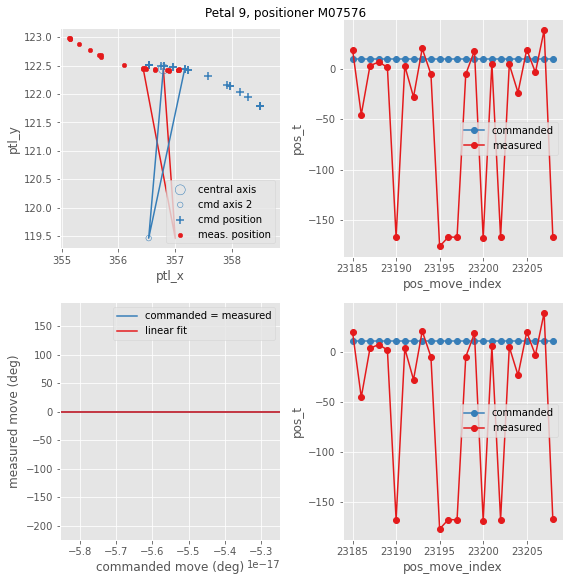

In [47]:
motortest.multi_plot_pos(9, 'M07576', p_moves, p_move_fits, 'p', figsize=(8,8))

# Linear fits to moves in each direction

(<Figure size 360x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaed729fa0>,
       dtype=object))

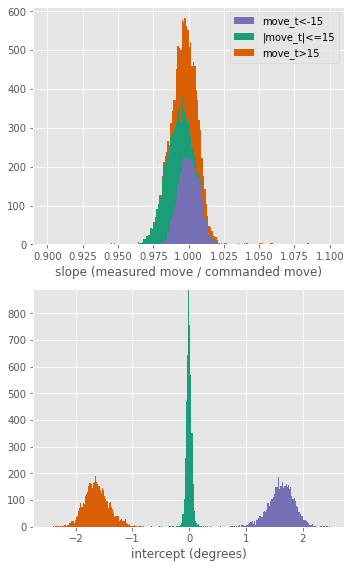

In [48]:
motortest.plot_move_fit_params_by_mag(t_moves, 't')

(<Figure size 360x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaee05b9d0>,
       dtype=object))

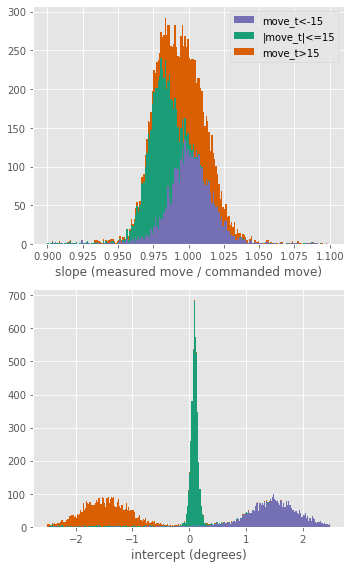

In [49]:
motortest.plot_move_fit_params_by_mag(p_moves, 'p')

# Compare linear scaling with `gear_calib_p`

Query the database for `gear_calib_p`:

In [50]:
logger.info("Querying gear calib data")
gear_calib_p = motortest.desidb_query("""
SELECT petal_id, pos_id, MIN(time_recorded), MAX(time_recorded), gear_calib_p
FROM positioner_calibration
WHERE gear_calib_p!=1
GROUP BY petal_id, pos_id, gear_calib_p
""", passwd).set_index(['petal_id', 'pos_id'], drop=False)
logger.info("Finished query")

2021-07-22 13:15:23,612 Querying gear calib data
2021-07-22 13:15:24,773 Finished query


In [51]:
gear_calib_p

,,petal_id,pos_id,min,max,gear_calib_p
petal_id,pos_id,,,,,
9,M02525,9,M02525,2021-02-19 01:56:09.148925+00:00,2021-02-19 01:56:09.148925+00:00,0.404
5,M04052,5,M04052,2021-02-05 02:50:22.336430+00:00,2021-06-23 01:47:11.582616+00:00,0.439
7,M01953,7,M01953,2021-02-05 02:50:22.164834+00:00,2021-06-23 01:47:11.589559+00:00,0.327
5,M04199,5,M04199,2021-04-03 23:44:42.005009+00:00,2021-06-23 01:47:11.582616+00:00,0.770
3,M03733,3,M03733,2021-04-03 23:44:42.023011+00:00,2021-06-23 01:47:11.582069+00:00,0.440
...,...,...,...,...,...,...
2,M03601,2,M03601,2021-04-03 23:44:42.021628+00:00,2021-05-26 03:53:21.850038+00:00,0.340
9,M07480,9,M07480,2021-04-03 23:44:42.168708+00:00,2021-05-27 23:26:28.948464+00:00,0.630
2,M03464,2,M03464,2021-02-05 02:50:22.161855+00:00,2021-04-01 03:02:09.793352+00:00,0.531


Text(0, 0.5, 'Fit slope (commanded/measured)')

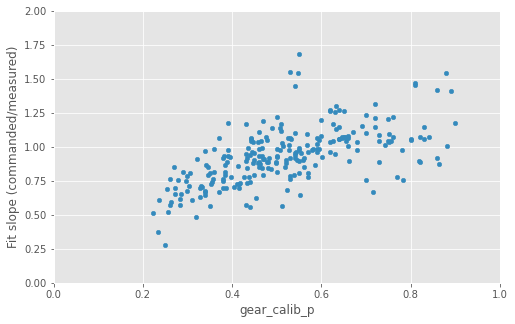

In [52]:
p_move_fits_wgear = p_move_fits.copy()
p_move_fits_wgear['gear_calib_p'] = gear_calib_p['gear_calib_p'].groupby(['petal_id', 'pos_id']).mean()
p_move_fits_wgear['gear_calib_p_inv'] = 1.0/p_move_fits_wgear['gear_calib_p']
p_move_fits_wgear['slope_inv'] = 1.0/p_move_fits_wgear['slope']
ax = p_move_fits_wgear.plot.scatter('gear_calib_p', 'slope_inv')
ax.set_ylim(0, 2)
ax.set_xlim(0, 1)
ax.set_ylabel("Fit slope (commanded/measured)")

In [53]:
1

1